#### Import packages

In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import requests
from io import StringIO

In [ ]:
%matplotlib notebook

#### Define the number of practice and experiment trials and parameters

In [ ]:
n_noCompetition = 24

n_grid_trials = 100

n_trials = 160

n_rand_trials = n_trials - n_grid_trials - n_noCompetition

n_Competition = n_trials - n_noCompetition

deadlines = [8,10,12]

#### Import Pezzulo gambles

In [ ]:
current_dir = os.getcwd()

path_to_csv = os.path.abspath(os.path.join(current_dir, 
                                           '../../../data_analysis/decision_making_models/hssm/parameter_recovery'))
pezzulo_gambles_files = f'{path_to_csv}/pezzulo_gambles.csv'

pezzulo_gambles = pd.read_csv(pezzulo_gambles_files)

n_pezzulo_rounds = len(pezzulo_gambles)

pezzulo_gambles.columns

In [ ]:
d_x_pezzulo = np.zeros(n_pezzulo_rounds)
d_p_pezzulo = np.zeros(n_pezzulo_rounds)
d_ev_pezzulo = np.zeros(n_pezzulo_rounds)


for i in range(n_pezzulo_rounds):
    lot_0_prob = pezzulo_gambles.iloc[i]['lot_0_prob']
    lot_0_val = pezzulo_gambles.iloc[i]['lot_0_val']
    lot_0_ev = pezzulo_gambles.iloc[i]['lot_0_ev']
    
    lot_1_prob = pezzulo_gambles.iloc[i]['lot_1_prob']
    lot_1_val = pezzulo_gambles.iloc[i]['lot_1_val']
    lot_1_ev = pezzulo_gambles.iloc[i]['lot_1_ev']
    
    d_x_pezzulo[i] = lot_0_val - lot_1_val
    d_p_pezzulo[i] = lot_0_prob - lot_1_prob
    d_ev_pezzulo[i] = lot_0_ev - lot_1_ev

#### Generate all possible lotteries

In [ ]:
#Function to generate all the possible lotteries
def generate_combinations():
    
    combinations = []
    
    #The first element is the value which can go from 1 to 100
    for i in range(1,100):  # First element: 1 to 99
        # The second element is the probability (in percentage) and can be anything beetween 1 and 100,
        for j in range(1,100): 
            
            #Calculate the expected value
            EV = i * (j/100)
            
            combinations.append([i,j,EV])
                
    sorted_combinations = sorted(combinations, key=lambda x: x[2])  # Sort by EV
    
    return sorted_combinations


all_combinations = generate_combinations()

#### Generate trials from grid criteria

In [ ]:
grid_gambles = np.zeros((10*10,11))

d_x_grid = np.zeros(10*10)
d_p_grid = np.zeros(10*10)
d_ev_grid = np.zeros(10*10)

counter = 0

for i in tqdm(range(10)):
    for j in range(10):
        
        gamble_valid = False
        
        while not gamble_valid:
            #Pick a random lottery
            lot_0 = random.choice(all_combinations)
            
            #Select all the lotteries that has a lower probability and a higher value
            desired_combinations = [vector for vector in all_combinations 
                                    if (lot_0[1] - vector[1]) > 0 and (lot_0[0] - vector[0]) <0]
            
            if(len(desired_combinations)>0):
                #print("true")
                lot_1 = random.choice(desired_combinations)
                
                dX = lot_0[0]-lot_1[0]
                dP = lot_0[1]-lot_1[1]
                
                lot_0_ev = lot_0[0]*(lot_0[1]/100)
                lot_1_ev = lot_1[0]*(lot_1[1]/100)
                
                dEV = lot_0_ev - lot_1_ev
                
                if (i*10) < dP < (10 +i*10):
                             
                    if (-j*10) > dX > (-10 - j*10):
                        
                        grid_gambles[counter,0] = counter + 1
                        grid_gambles[counter,1] = lot_0[0]
                        grid_gambles[counter,2] = lot_0[1]
                        grid_gambles[counter,3] = lot_0_ev           
                        grid_gambles[counter,4] = lot_1[0]
                        grid_gambles[counter,5] = lot_1[1]
                        grid_gambles[counter,6] = lot_1_ev
                        grid_gambles[counter,7] = dX
                        grid_gambles[counter,8] = dP
                        grid_gambles[counter,9] = dEV
                        
                        #Flag to say if there is attribute competition
                        grid_gambles[counter,10] = 1
                        
                        #Pick a random deadline
                        #grid_gambles[counter,11] = np.random.choice(deadlines)
                        
                        d_x_grid[counter] = dX 
                        d_p_grid[counter] = dP
                        d_ev_grid[counter] = dEV
                        
                        counter += 1
                        
                        gamble_valid = True        

#### Generate random trials

In [ ]:
random_gambles = np.zeros((n_rand_trials,11))

d_x_rand = np.zeros(n_rand_trials)
d_p_rand = np.zeros(n_rand_trials)
d_ev_rand = np.zeros(n_rand_trials)

for i in tqdm(range(n_rand_trials,)):
       
    gamble_valid = False
    
    rand_dx_ind = random.randint(0, 9)
    rand_dp_ind = random.randint(0, 9)
            
    while not gamble_valid:
        #Pick a random lottery
        lot_0 = random.choice(all_combinations)
            
        #Select all the lotteries that has a lower probability and a higher value
        desired_combinations = [vector for vector in all_combinations 
                                if (lot_0[1] - vector[1]) > 0 and (lot_0[0] - vector[0]) <0]
            
        if(len(desired_combinations)>0):

            lot_1 = random.choice(desired_combinations)
                
            dX = lot_0[0]-lot_1[0]
            dP = lot_0[1]-lot_1[1]
                
            lot_0_ev = lot_0[0]*(lot_0[1]/100)
            lot_1_ev = lot_1[0]*(lot_1[1]/100)
                
            dEV = lot_0_ev - lot_1_ev
                
            if (rand_dp_ind*10) < dP < (10 +rand_dp_ind*10):
                             
                if (-rand_dx_ind*10) > dX > (-10 - rand_dx_ind*10):
                        
                    random_gambles[i,0] = int(n_grid_trials + i + 1)
                    random_gambles[i,1] = int(lot_0[0])
                    random_gambles[i,2] = int(lot_0[1])
                    random_gambles[i,3] = lot_0_ev           
                    random_gambles[i,4] = int(lot_1[0])
                    random_gambles[i,5] = int(lot_1[1])
                    random_gambles[i,6] = lot_1_ev
                    random_gambles[i,7] = dX
                    random_gambles[i,8] = dP
                    random_gambles[i,9] = dEV
                    
                    #Flag to say if there is attribute competition
                    random_gambles[i,10] = 1
                    
                    #Pick a random deadline
                    #random_gambles[i,11] = np.random.choice(deadlines)

                    d_x_rand[i] = dX 
                    d_p_rand[i] = dP
                    d_ev_rand[i] = dEV

                    gamble_valid = True

#### Add deadlines

In [ ]:
deadline_8_array = np.ones(46)*8
deadline_10_array = np.ones(45)*10
deadline_12_array = np.ones(45)*12

all_deadlines_array = np.concatenate([deadline_8_array,deadline_10_array,deadline_12_array])

# Shuffle the array
np.random.shuffle(all_deadlines_array)

In [ ]:
grid_gambles = np.hstack((grid_gambles, all_deadlines_array[:n_grid_trials].reshape(-1, 1)))
random_gambles = np.hstack((random_gambles, all_deadlines_array[n_grid_trials:].reshape(-1, 1)))

#### Generate easy gambles

In [ ]:
easy_gambles = np.zeros((n_noCompetition,12))

d_x_easy = np.zeros(n_noCompetition)
d_p_easy = np.zeros(n_noCompetition)
d_ev_easy = np.zeros(n_noCompetition)

for i in tqdm(range(n_noCompetition)):

    gamble_valid = False
        
    while not gamble_valid:
        #Pick a random lottery
        lot_0 = random.choice(all_combinations)
            
        #Select all the lotteries that has a lower probability and a lower value
        desired_combinations = [vector for vector in all_combinations 
                                if (lot_0[1] - vector[1]) > 0 and (lot_0[0] - vector[0]) > 0]
            
        if(len(desired_combinations)>0):

            lot_1 = random.choice(desired_combinations)
                
            dX = lot_0[0]-lot_1[0]
            dP = lot_0[1]-lot_1[1]
                
            lot_0_ev = lot_0[0]*(lot_0[1]/100)
            lot_1_ev = lot_1[0]*(lot_1[1]/100)
                
            dEV = lot_0_ev - lot_1_ev
                
            easy_gambles[i,0] = int(n_grid_trials + n_rand_trials + i + 1)
            
            easy_gambles[i,1] = int(lot_0[0])
            easy_gambles[i,2] = int(lot_0[1])
            easy_gambles[i,3] = lot_0_ev        
            easy_gambles[i,4] = int(lot_1[0])
            easy_gambles[i,5] = int(lot_1[1])
            easy_gambles[i,6] = lot_1_ev
            easy_gambles[i,7] = dX
            easy_gambles[i,8] = dP
            easy_gambles[i,9] = dEV
            
            #Flag to say if there is attribute competition
            easy_gambles[i,10] = 0
            
            #Assign deadlines
            if i < int(n_noCompetition/3):
                easy_gambles[i,11] = 8
            elif int(n_noCompetition/3) <= i < 2*int(n_noCompetition/3):
                easy_gambles[i,11] = 10
            else:
                easy_gambles[i,11] = 12

            d_x_easy[i] = dX 
            d_p_easy[i] = dP
            d_ev_easy[i] = dEV

            gamble_valid = True        

#### Check obtained trials

In [ ]:
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter plot with x, y, and z coordinates
ax.scatter(d_x_grid, d_p_grid, d_ev_grid, color = "blue")
#ax.scatter(d_x_pezzulo, d_p_pezzulo, d_ev_pezzulo, color = "red")
ax.scatter(d_x_rand, d_p_rand, d_ev_rand, color = "brown")

# Label the axes
ax.set_xlabel('dX Coordinate')
ax.set_ylabel('dP Coordinate')
ax.set_zlabel('dEV Coordinate')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()


ax.plot([xlim[0], xlim[1]], [0, 0], [0, 0], color='r', linewidth=2, label='dX-axis')

# Draw the y-axis
ax.plot([0, 0], [ylim[0], ylim[1]], [0, 0], color='g', linewidth=2, label='dP-axis')

# Draw the z-axis
ax.plot([0, 0], [0, 0], [zlim[0], zlim[1]], color='b', linewidth=2, label='dEV-axis')


# Display the plot
plt.show()

#### Save gambles

In [ ]:
column_names = ["GambleNumber",
                "lot_0_val",
                "lot_0_prob",
                "lot_0_ev",
                "lot_1_val",
                "lot_1_prob",
                "lot_1_ev",
                "dX",
                "dP",
                "dEV",
                "AttributeCompetition",
                "Deadline"]

In [ ]:
all_gambles_array = np.concatenate((grid_gambles, random_gambles, easy_gambles))

# Creating a DataFrame
gambles_df = pd.DataFrame(all_gambles_array, columns=column_names)

In [ ]:
path_to_folder = r'C:\Users\Administrator\OneDrive - UGent\Experiments\risky_dm\application\src\static\gambles'

In [ ]:
gambles_file = f'{path_to_folder}/gambles.csv'
gambles_df.to_csv(gambles_file, index=False)

#### Generate practice trials

In [ ]:
array = np.array([[1, 60,50,30, 30,20,6, 30,30,24, 0, 8], 
                  [2, 40,50,20, 75,24,18, -35,26,2, 1, 10,], 
                  [3, 3,6,0.18, 9,2,0.18, -6,4,0, 1, 12],
                  [4, 40,80,32, 90,10,9, -50,70,23, 1, 10], 
                  [5, 10,90,9, 20,45,9, -10,45,0, 1, 8], 
                  [6, 80,90,72, 20,1,2, 60,89,70, 0, 12]])

In [ ]:
column_names = ["PracticeGambleNumber",
                "lot_0_val",
                "lot_0_prob",
                "lot_0_ev",
                "lot_1_val",
                "lot_1_prob",
                "lot_1_ev",
                "dX",
                "dP",
                "dEV",
                "AttributeCompetition",
                "Deadline"]

In [ ]:
practice_gambles_df = pd.DataFrame(array, columns = column_names)

In [ ]:
path_to_folder = r'C:\Users\Administrator\OneDrive - UGent\Experiments\risky_dm\application\src\static\gambles'

In [ ]:
practice_gambles_file = f'{path_to_folder}/practice_gambles.csv'
practice_gambles_df.to_csv(practice_gambles_file, index=False)

## Generate experiment and practice trials for pilot 2 (risky_dm_1)

#### Import experiment and practice trials of risky_dm_0

In [ ]:
current_dir = os.getcwd()

path_to_csv = os.path.abspath(os.path.join(current_dir, 
                                           '../static/gambles'))
gambles_files = f'{path_to_csv}/gambles_risky_dm_0.csv'

gambles_risky_dm_0 = pd.read_csv(gambles_files)

n_trials = len(gambles_risky_dm_0)

gambles_risky_dm_0.columns


practice_gambles_files = f'{path_to_csv}/practice_gambles_risky_dm_0.csv'

practice_gambles_risky_dm_0 = pd.read_csv(practice_gambles_files)

practice_gambles_risky_dm_0.columns

In [ ]:
# Reduce the deadlines by 2 seconds:

gambles_risky_dm_1 = gambles_risky_dm_0.copy()

# Subtract 2 from the 'Deadline' column
gambles_risky_dm_1['Deadline'] = gambles_risky_dm_1['Deadline'] - 2

# Display the first few rows to check
print(gambles_risky_dm_1.head())

In [ ]:
# Reduce the deadlines by 2 seconds:

practice_gambles_risky_dm_1 = practice_gambles_risky_dm_0.copy()

# Subtract 2 from the 'Deadline' column
practice_gambles_risky_dm_1['Deadline'] = practice_gambles_risky_dm_1['Deadline'] - 2

# Display the first few rows to check
print(practice_gambles_risky_dm_1.head())

#### Save practice and experiment trials for risky_dm_1 experiment

In [ ]:
practice_gambles_file = f'{path_to_csv}/practice_gambles_risky_dm_1.csv'
practice_gambles_risky_dm_1.to_csv(practice_gambles_file, index=False)

In [ ]:
gambles_file = f'{path_to_csv}/gambles_risky_dm_1.csv'
gambles_risky_dm_1.to_csv(gambles_file, index=False)

## Generate gambles for pilot 3

In pilot 3, we pick a subset of gambles from experiment 2 (64)

#### Import gambles from experiment 2

In [2]:
# Experiment version
exp_version = 2

#Nextcloud credentials
username = 'algarrid'
password = 'faunistico'

In [6]:
current_dir = os.getcwd()

# Path to where the csv file is relative to the current script's directory
path_to_csv = os.path.abspath(os.path.join(current_dir, 
                                           '../static/gambles'))

# Construct the full paths to the CSV files within the folder
gambles_files = f'{path_to_csv}/gambles_risky_dm_'+str(exp_version)+'.csv'

gambles= pd.read_csv(gambles_files)

n_rounds = len(gambles)

deadlines = np.unique(gambles['Deadline'])

print(gambles.columns)

Index(['GambleNumber', 'lot_0_val', 'lot_0_prob', 'lot_0_ev', 'lot_1_val',
       'lot_1_prob', 'lot_1_ev', 'dX', 'dP', 'dEV', 'AttributeCompetition',
       'Deadline'],
      dtype='object')


#### Import data from experiment 2

In [8]:
# URL of the CSV file you want to access (use the full path to the file)
if exp_version == 2:
    file_url = (
        'https://cloud.ilabt.imec.be/remote.php/dav/files/'+
        'af741990-37f9-103d-9441-9bec5c4808a7/ExperimentsData/'+
        'risky_dm_'+str(exp_version)+'/ExperimentData/experiment_reprotaskmethod1quest1_answers.csv'            
    )
else: 
    file_url = (
        'https://cloud.ilabt.imec.be/remote.php/dav/files/'+
        'af741990-37f9-103d-9441-9bec5c4808a7/ExperimentsData/'+
        'risky_dm_'+str(exp_version)+'/pilot/experiment_rounds_answers.csv'            
    )
# Make a request to get the file content
response = requests.get(file_url, auth=(username, password))

# Check if the request was successful
if response.status_code == 200:
    # Stream the content directly into a pandas DataFrame
    csv_content = StringIO(response.text)
    df_experiment = pd.read_csv(csv_content)

    # Now `df` is your DataFrame containing the CSV data
    print("Data downloaded")  # Example: print the first few rows
else:
    print(f"Failed to retrieve the file. Status code: {response.status_code}")

#Fix bug of experiment 2.
if exp_version == 2:
    df_experiment.loc[
        (df_experiment['ResponseTimeGamble'] > 8) & (df_experiment['GambleFinalDeadline'] == 8), 
        'GambleFinalDeadline'
    ] = 10

df_experiment.columns

Data downloaded


Index(['StudyID', 'SessionID', 'ExperimentRoundID', 'ParticipantID',
       'BlockNumber', 'ExperimentRoundNumber', 'ExperimentGambleNumber',
       'LotteryLeft', 'LotteryRight', 'GambleChoice', 'ResponseTimeGamble',
       'GambleSecondaryChoices', 'GambleSecondaryChoicesTimes',
       'GamblePresetDeadline', 'GambleFinalDeadline', 'FullScreenExited',
       'ReproducedTime', 'MissedMaxDeadline', 'SubjectiveDifficulty',
       'ResponseTimeSubjectiveDifficulty',
       'ResponseTimeSubmitAnswersQuestionnaire'],
      dtype='object')

#### Data cleaning

In [9]:
if exp_version == 2:

    df_experiment = df_experiment[df_experiment['FullScreenExited'] == 0]

    rejected_participants_list = ['670ca14484c2bdc633b10f21',
                                  '622e282986d38f7f8fb74e93', 
                                  '6691b722e54f9a743dfd308c',
                                  '6658ca018e28e3383feae8e9', 
                                  '62ac71cec3309a48781684eb',
                                  '6658b14e39f5e53a96a6a8f4']
    df_experiment = df_experiment[~df_experiment['ParticipantID'].isin(rejected_participants_list)] # Remove all rejected participants
    par_ids = np.unique(df_experiment['ParticipantID'])
    n_par = len(par_ids)
else :
    
    df_experiment = df_experiment[(df_experiment['MissedDeadline'] == 0)]

In [192]:
gambles_id_and_median_rt = np.zeros((n_rounds,10))

for i in range(n_rounds):
    
    df_current_gamble = df_experiment[df_experiment['ExperimentGambleNumber'] == i+1]
    rt = df_current_gamble['ResponseTimeGamble']
    current_gamble = gambles[gambles['GambleNumber'] == i+1]
    
    gambles_id_and_median_rt[i,0] = np.median(rt)  
    gambles_id_and_median_rt[i,1] = current_gamble['lot_0_val'].iloc[0]
    gambles_id_and_median_rt[i,2] = current_gamble['lot_0_prob'].iloc[0]
    gambles_id_and_median_rt[i,3] = current_gamble['lot_0_ev'].iloc[0]
    gambles_id_and_median_rt[i,4] = current_gamble['lot_1_val'].iloc[0]
    gambles_id_and_median_rt[i,5] = current_gamble['lot_1_prob'].iloc[0]
    gambles_id_and_median_rt[i,6] = current_gamble['lot_1_ev'].iloc[0]
    gambles_id_and_median_rt[i,7] = current_gamble['dX'].iloc[0]
    gambles_id_and_median_rt[i,8] = current_gamble['dP'].iloc[0]
    gambles_id_and_median_rt[i,9] = current_gamble['dEV'].iloc[0]
    

In [193]:
sorted_gambles = gambles_id_and_median_rt[gambles_id_and_median_rt[:, 0].argsort()]

In [200]:
easy_gambles = sorted_gambles[
    (sorted_gambles[:, 0] <= 2.06) &  
    (sorted_gambles[:, -1] >= 15) 
]

medium_gambles = sorted_gambles[
    (sorted_gambles[:, 0] >= 2.4) & (sorted_gambles[:, 0] <= 3.1) 

]

medium_gambles = medium_gambles[
    ((medium_gambles[:, -1] >= -40) & (medium_gambles[:, -1] <= -15)) |
    ((medium_gambles[:, -1] >= 10) & (medium_gambles[:, -1] <= 15)) 
]


hard_gambles = sorted_gambles[-22:]

# Shuffle the rows
np.random.shuffle(easy_gambles)
np.random.shuffle(medium_gambles)
np.random.shuffle(hard_gambles)


In [201]:
print("Number of easy gambles: "+str(len(easy_gambles)))
print("Number of medium gambles: "+str(len(medium_gambles)))
print("Number of hard gambles: "+str(len(hard_gambles)))
print("Total number of gambles: "+str(len(easy_gambles) + len(medium_gambles) + len(hard_gambles)))

Number of easy gambles: 21
Number of medium gambles: 21
Number of hard gambles: 22
Total number of gambles: 64


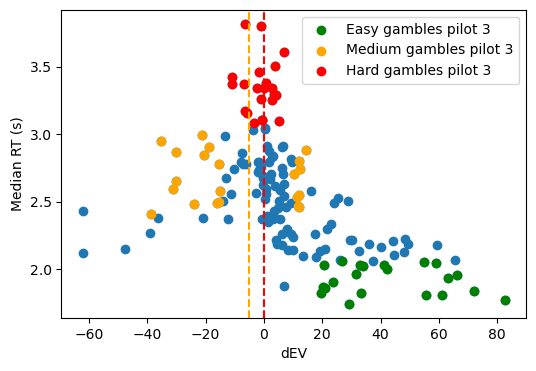

In [202]:
plt.figure(figsize=(6, 4))
plt.scatter(gambles_id_and_median_rt[:,-1], gambles_id_and_median_rt[:,0])
plt.scatter(easy_gambles[:,-1],easy_gambles[:,0], label="Easy gambles pilot 3", color = "green")
plt.scatter(medium_gambles[:,-1],medium_gambles[:,0], label="Medium gambles pilot 3", color = "orange")
plt.scatter(hard_gambles[:,-1],hard_gambles[:,0], label="Hard gambles pilot 3", color = "red")

plt.xlabel("dEV")
plt.ylabel("Median RT (s)")
plt.axvline(x=0, color='red', linestyle='--')  # Vertical line at x = 0, blue dotted line
plt.axvline(x=-5, color='orange', linestyle='--')  # Vertical line at x = 0, blue dotted line
plt.legend()
plt.show()

#### Add deadlines and labels for gambles of pilot 3

In [203]:
deadlines_easy_and_medium_gambles = np.array([6,6,6,6,6,6,6,8,8,8,8,8,8,8,10,10,10,10,10,10,10])
deadlines_hard_gambles = np.array([6,6,6,6,6,6,6,6,8,8,8,8,8,8,8,10,10,10,10,10,10,10])

easy_gambles_array = np.column_stack((easy_gambles, deadlines_easy_and_medium_gambles))
medium_gambles_array = np.column_stack((medium_gambles, deadlines_easy_and_medium_gambles))
hard_gambles_array = np.column_stack((hard_gambles, deadlines_hard_gambles))

gambles_array = np.vstack((easy_gambles_array,medium_gambles_array,hard_gambles_array))

#gambles_array = np.delete(gambles_array, 1, axis=1)

gambles_labels = np.arange(1, 65)

gambles_array = np.column_stack((gambles_labels,gambles_array))

#gambles_array[:, 0] = gambles_array[:, 0].astype(int)

In [204]:
deadline_6_gambles = gambles_array[gambles_array[:, -1] == 6]
deadline_8_gambles = gambles_array[gambles_array[:, -1] == 8]
deadline_10_gambles = gambles_array[gambles_array[:, -1] == 10]

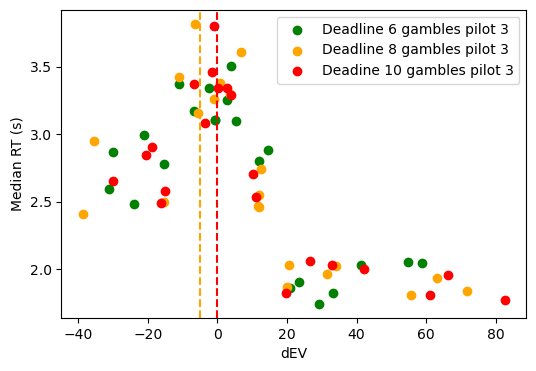

In [205]:
plt.figure(figsize=(6, 4))
plt.scatter(deadline_6_gambles[:,-2],deadline_6_gambles[:,1], label="Deadline 6 gambles pilot 3", color = "green")
plt.scatter(deadline_8_gambles[:,-2],deadline_8_gambles[:,1], label="Deadline 8 gambles pilot 3", color = "orange")
plt.scatter(deadline_10_gambles[:,-2],deadline_10_gambles[:,1], label="Deadine 10 gambles pilot 3", color = "red")

plt.xlabel("dEV")
plt.ylabel("Median RT (s)")
plt.axvline(x=0, color='red', linestyle='--')  # Vertical line at x = 0, blue dotted line
plt.axvline(x=-5, color='orange', linestyle='--')  # Vertical line at x = 0, blue dotted line
plt.legend()
plt.show()

#### Save gambles for pilot 3

In [206]:
column_names = ["GambleNumber",
                "lot_0_val",
                "lot_0_prob",
                "lot_0_ev",
                "lot_1_val",
                "lot_1_prob",
                "lot_1_ev",
                "dX",
                "dP",
                "dEV",
                "Deadline"]


In [207]:
gambles_array = np.delete(gambles_array, 1, axis=1)

# Creating a DataFrame
gambles_pilot_3_df = pd.DataFrame(gambles_array, columns=column_names)

current_dir = os.getcwd()

path_to_csv = os.path.abspath(os.path.join(current_dir, 
                                           '../static/gambles'))

gambles_file = f'{path_to_csv}/gambles_risky_dm_3.csv'
gambles_pilot_3_.to_csv(gambles_file, index=False)